<a href="https://colab.research.google.com/github/KarolRolinski/Predictive-maintenance/blob/main/LinearReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from sklearn.model_selection import train_test_split


from google.colab import files
uploaded = files.upload()

Saving data.txt to data.txt


In [3]:
import io

ds = pd.read_fwf(io.BytesIO(uploaded['data.txt']))
ds.columns = ["Lever_position", "Ship_Speed", "Turb_Shaft_Torque", "Turb_Rate", "Gen_Rate", "Star_Prop_Torque", "Port_Prop_Torque", "HP_Turb_Temp", "Comp_In_Temp", "Comp_Out_Temp", "HP_Turb_Exit_Pres", "Comp_In_Pres", "Comp_Out_Pres", "Turb_Exh_Pres", "Turb_Inj_Ctrl", "Fuel", "Comp_decay_state", "Turb_decay_state"]
ds = ds.drop(columns = ["Comp_In_Temp", "Comp_In_Pres", "Star_Prop_Torque", "Port_Prop_Torque"])
y_comp = ds.pop("Comp_decay_state")
y_turb = ds.pop("Turb_decay_state")
ds_train, ds_test, yt_train, yt_test = train_test_split( ds, y_turb, test_size = 1/3, random_state = 0)

feature_t = []
for key in ds_train.keys():
  feature_t.append(tf.feature_column.numeric_column(key=key))

def make_input_fn(data_df, label_df, num_epochs=800, shuffle=True, batch_size=80):
  def input_function(): 
    ds_tf = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds_tf = ds_tf.shuffle(1000) 
    ds_tf = ds_tf.batch(batch_size).repeat(num_epochs) 
    return ds_tf
  return input_function 

train_input_fn_t = make_input_fn(ds_train, yt_train) 
eval_input_fn_t = make_input_fn(ds_test, yt_test, num_epochs=1, shuffle=False)

In [5]:
%%time 

learn = 0.0001
beta1 = 0.7
beta2 = 0.99
eps = 1e-07

linear_est_t = tf.estimator.LinearRegressor(feature_columns = feature_t, optimizer=tf.keras.optimizers.Adam(learning_rate=learn, beta_1=beta1, beta_2=beta2, epsilon=eps, amsgrad=True, name='Adam')) 
linear_est_t.train(train_input_fn_t)  
result_t = linear_est_t.evaluate(eval_input_fn_t)
predic_t = list(linear_est_t.predict(eval_input_fn_t))
clear_output() 

CPU times: user 2min 41s, sys: 7.4 s, total: 2min 49s
Wall time: 2min 25s


In [6]:
probs_t = pd.Series([pred['predictions'] for pred in predic_t])
probs_t = probs_t.astype(float)
yt_por = yt_test.reset_index(drop=True)
loss = tf.reduce_mean(tf.square(probs_t - yt_por))
compare_t = pd.concat([yt_por, probs_t], axis=1)
print(predic_t)
print(loss)



[{'predictions': array([0.99838614], dtype=float32)}, {'predictions': array([0.9925768], dtype=float32)}, {'predictions': array([0.98360944], dtype=float32)}, {'predictions': array([0.995485], dtype=float32)}, {'predictions': array([0.96895635], dtype=float32)}, {'predictions': array([0.98440874], dtype=float32)}, {'predictions': array([0.9809734], dtype=float32)}, {'predictions': array([0.99105716], dtype=float32)}, {'predictions': array([0.9829659], dtype=float32)}, {'predictions': array([0.99284065], dtype=float32)}, {'predictions': array([0.9867239], dtype=float32)}, {'predictions': array([0.992326], dtype=float32)}, {'predictions': array([0.98902696], dtype=float32)}, {'predictions': array([0.9875185], dtype=float32)}, {'predictions': array([0.99875855], dtype=float32)}, {'predictions': array([0.9744733], dtype=float32)}, {'predictions': array([0.9841919], dtype=float32)}, {'predictions': array([0.9781225], dtype=float32)}, {'predictions': array([0.99939334], dtype=float32)}, {'pr

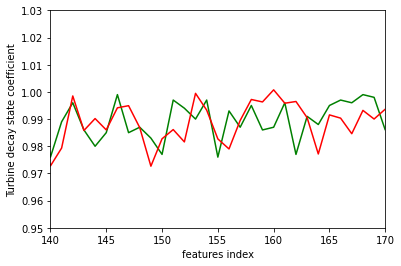

In [14]:
x = range(1, 3979)
y1 = yt_por
y2 = probs_t
plt.plot(x, y1, 'g', y2, 'r')
plt.axis([140, 170, 0.95, 1.03])
plt.xlabel('Features index')
plt.ylabel('Turbine decay state coefficient')
clear_output()